Итак, здесь вы начинаете работу над своим небольшим проектом. Напоминаем — работать нужно с данными по ВВП Ганы. Выполняйте все задания проекта в одном Jupyter-ноутбуке.

In [1]:
from typing import Callable, Optional
from warnings import filterwarnings

import jupyter_black
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from arch import arch_model
from pmdarima import auto_arima
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
filterwarnings("ignore")

In [3]:
jupyter_black.load(lab=False, line_length=79)

In [4]:
%matplotlib inline

In [5]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

# Статистические модели прогнозирования

In [6]:
df = pd.read_csv("ghana_gdp.csv", parse_dates=["year"], index_col="year")

In [7]:
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [8]:
df.tail()

,GDP (current US$)
year,
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


In [9]:
df.size

62

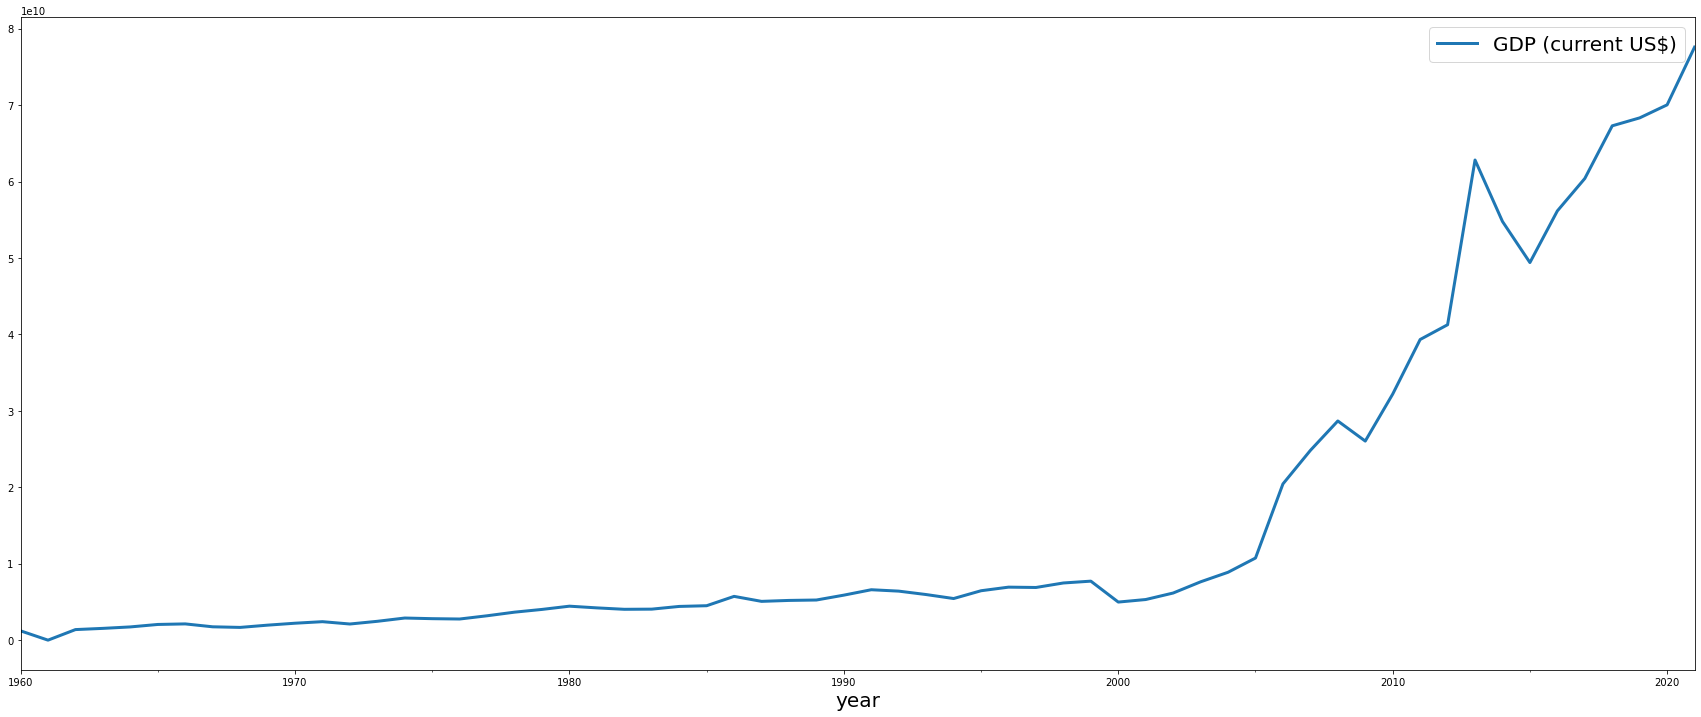

In [10]:
df.plot()
plt.show()

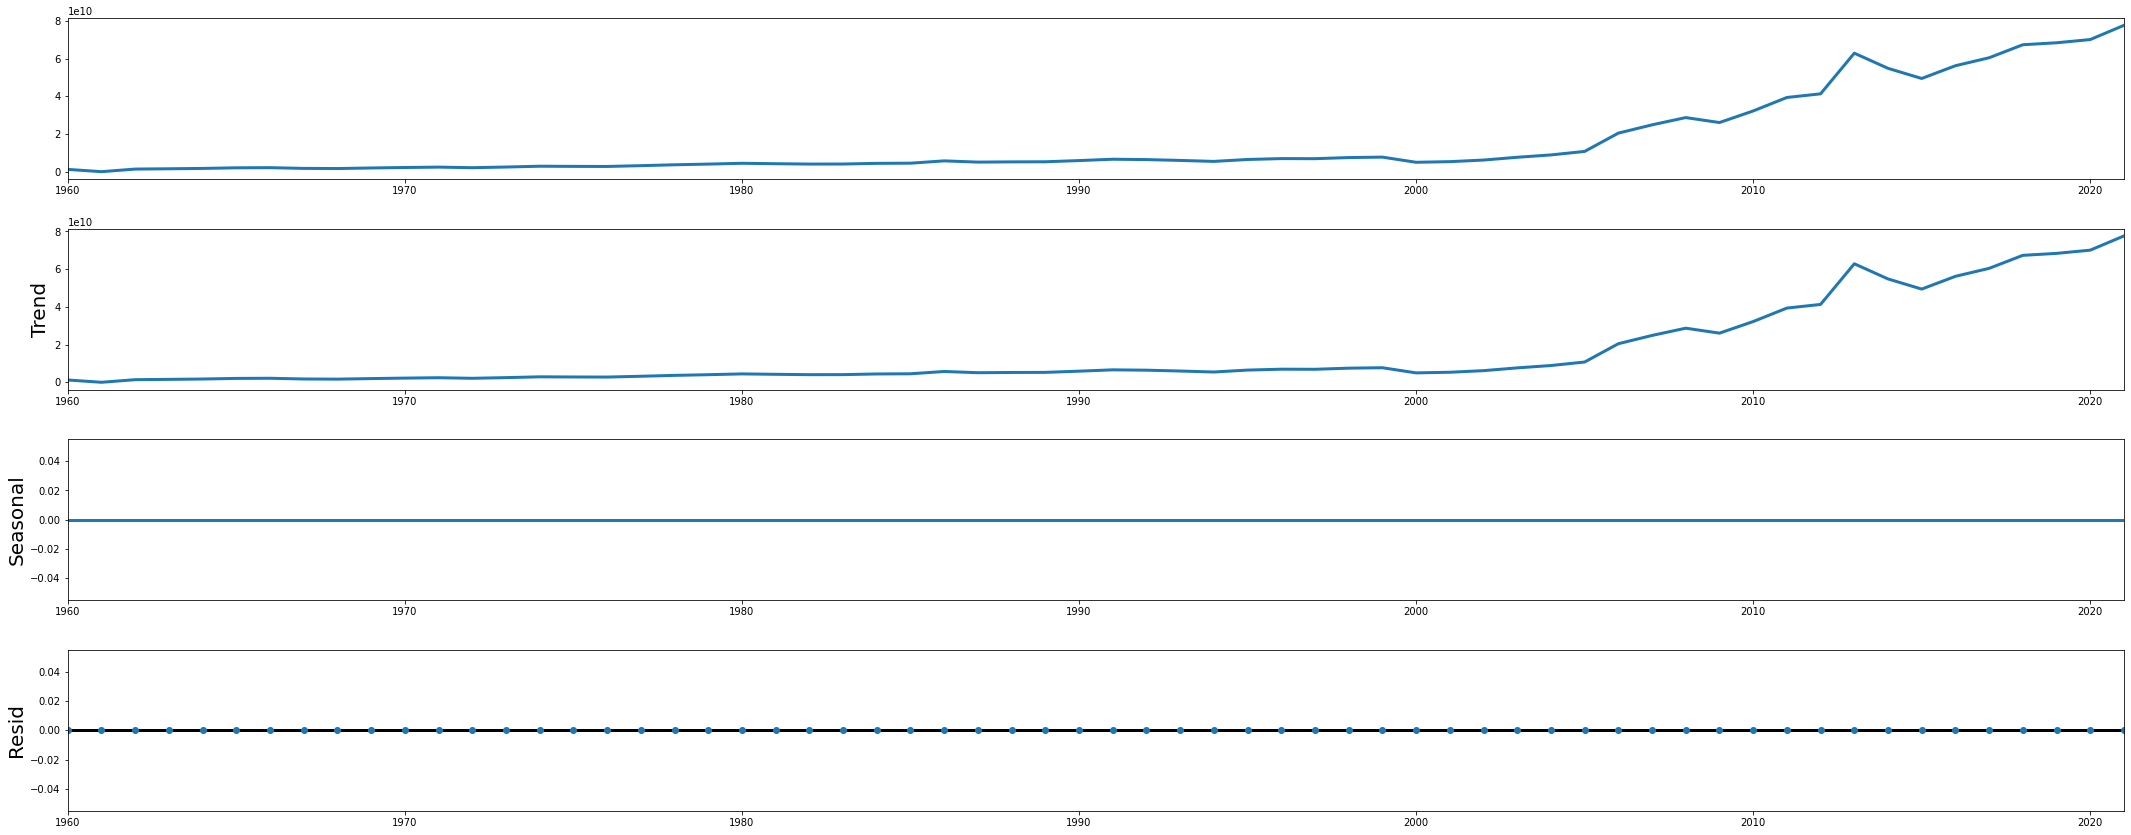

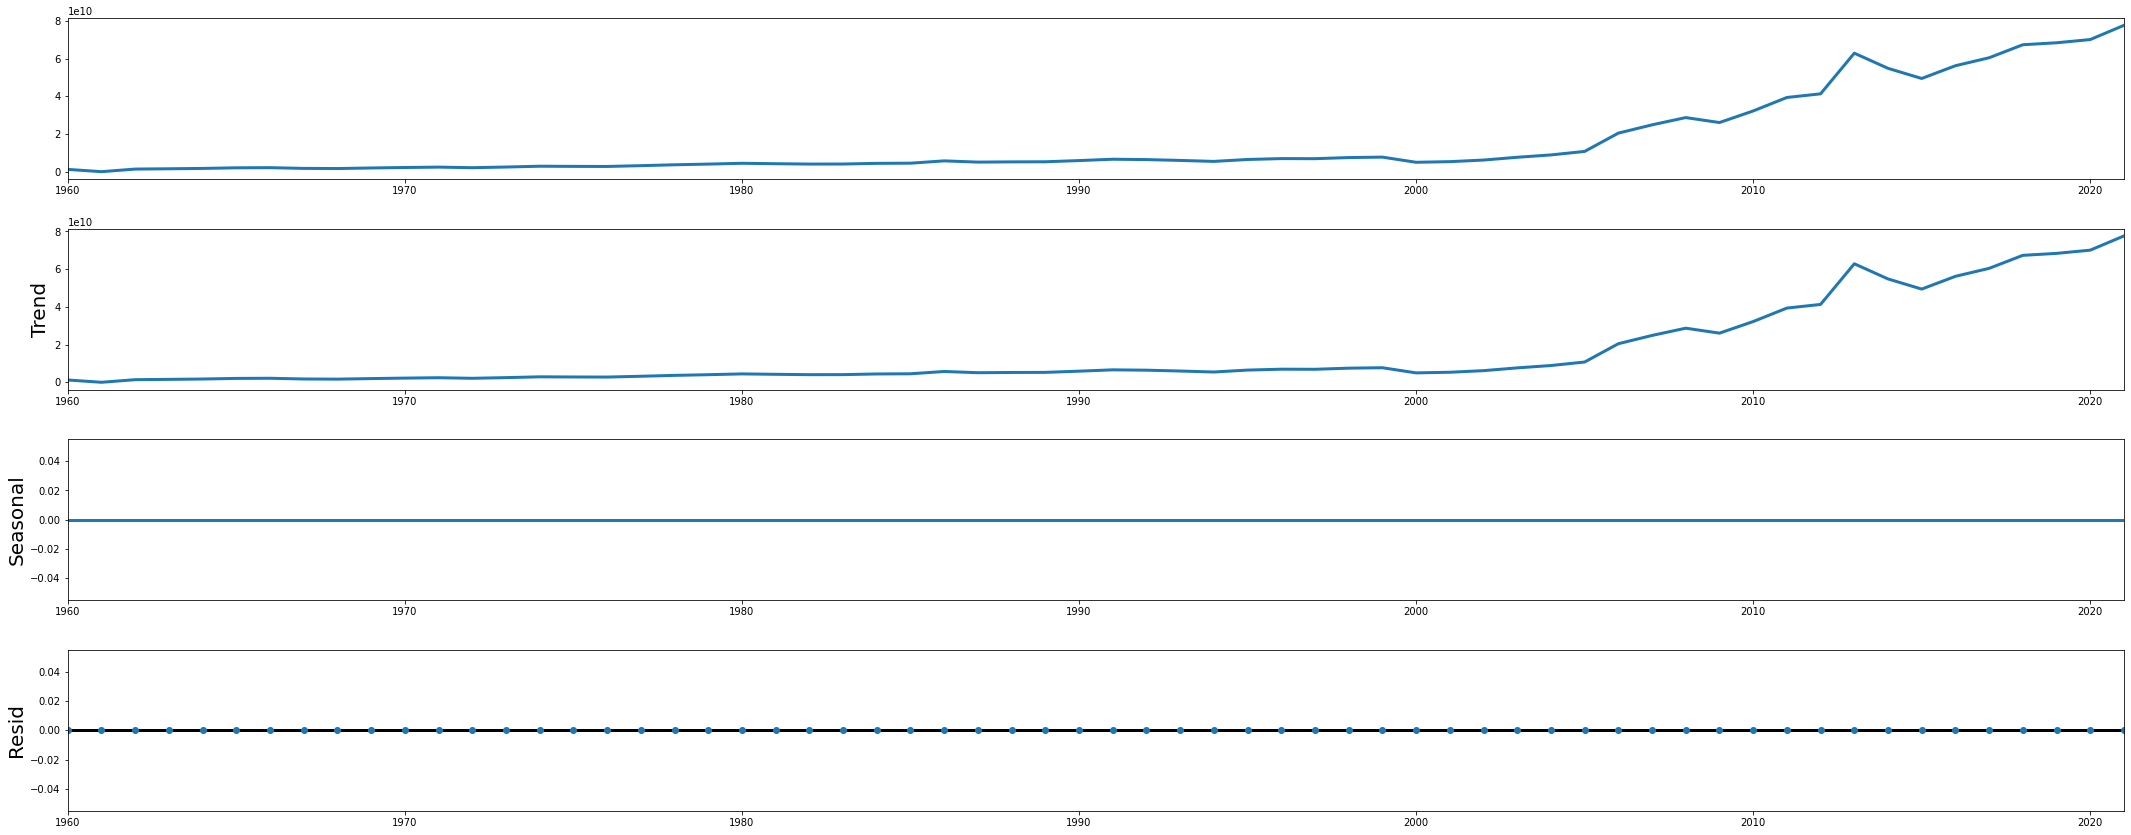

In [11]:
seasonal_decompose(df).plot()

Отложите последние три года датасета как тестовую выборку для оценки результатов предсказания.

In [12]:
df_train = df.iloc[:-3]
df_test = df.iloc[-3:]

Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

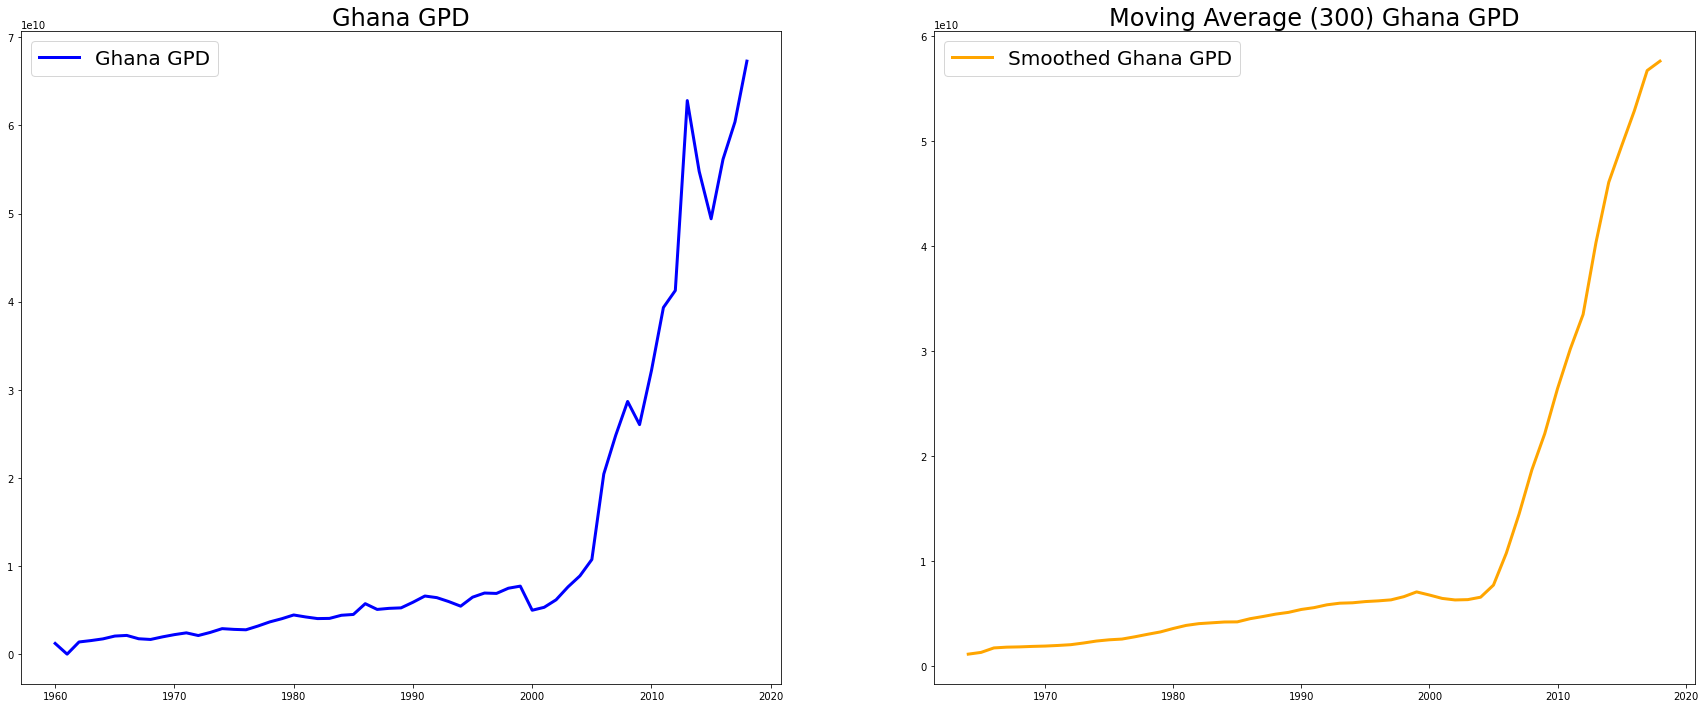

In [13]:
fig, ax = plt.subplots(1, 2)

# Окно в 5 лет (Window = 5)
ax[0].plot(df_train["GDP (current US$)"], color="blue", label="Ghana GPD")
ax[0].set_title("Ghana GPD")
ax[0].legend()

ax[1].plot(
    df_train["GDP (current US$)"].rolling(window=5).mean(),
    color="orange",
    label="Smoothed Ghana GPD",
)
ax[1].set_title("Moving Average (300) Ghana GPD")
ax[1].legend()

plt.show()

Оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA. Выберите парамeтры p и q по коррелограммам ACF и PACF. Также постройте модель с параметрами, ближайшими к p и q, и сравните коэффициент AIC или подберите наилучшие параметры с помощью pmdarima, как в скринкасте.

In [14]:
def diff_n(series: pd.Series, n: int) -> pd.Series:
    """
    Дифференцирует временной ряд заданного порядка.

    Args:
        series: временной ряд
        n: порядок дифференцирования

    Returns:
        продифференцированный ряд заданного порядка
    """
    for i in range(n):
        series = series.diff().dropna()

    return series

In [15]:
def is_stationary(series: pd.Series) -> bool:
    """
    Определяет, является ли ряд стационарным.

    Args:
        series: временной ряд

    Returns:
        True, если ряд является стационарным, иначе False
    """
    test = adfuller(series.dropna())
    print("adf: ", test[0])
    print("p-value: ", test[1])
    print("Critical values: ", test[4])
    return test[0] <= test[4]["5%"]

In [16]:
is_stationary(df_train["GDP (current US$)"])

adf:  0.6529066974885412
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


False

Ряд нестационарный, поэтому нам нужна модель ARIMA.

In [17]:
is_stationary(diff_n(df_train["GDP (current US$)"], 1))

adf:  -1.67024830383208
p-value:  0.446502932971388
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}


False

In [18]:
is_stationary(diff_n(df_train["GDP (current US$)"], 2))

adf:  -2.6408690561284893
p-value:  0.08484116917837681
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}


False

In [19]:
is_stationary(diff_n(df_train["GDP (current US$)"], 3))

adf:  -4.779623784828548
p-value:  5.948327640224507e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


True

Ряд является интегрированным рядом третьего порядка.

Теперь определим порядок моделей AR и MA по графику частичной автокорреляции.

In [20]:
d = 3

In [21]:
def plot_correlogram(
    series: pd.Series,
    plot_function: Callable,
    ax: Optional[matplotlib.axes.Axes] = None,
    alpha: float = 0.05,
) -> None:
    """
    Строит коррелограмму acf или pacf для временного ряда.

    Args:
        series: временной ряд
        corr_function: функция построения коррелограммы
        ax: оси, на которых нужно построить коррелограмму
        alpha: доверительный интервал

    Raises:
        ValueError, если функция построения коррелограммы неправильная
    """
    lags = round(len(series) / 4)

    if plot_function.__name__ == "plot_acf":
        plot_function(series, ax=ax, lags=lags, alpha=alpha, zero=False)
    elif plot_function.__name__ == "plot_pacf":
        plot_function(
            series, ax=ax, lags=lags, alpha=alpha, method="ywm", zero=False
        )
    else:
        raise ValueError("Incorrect plot function")

    ax.xaxis.set_ticks(np.arange(0, lags + 1, 1))
    ax.yaxis.set_ticks(np.arange(-1.0, 1.0, 0.1))
    ax.grid()

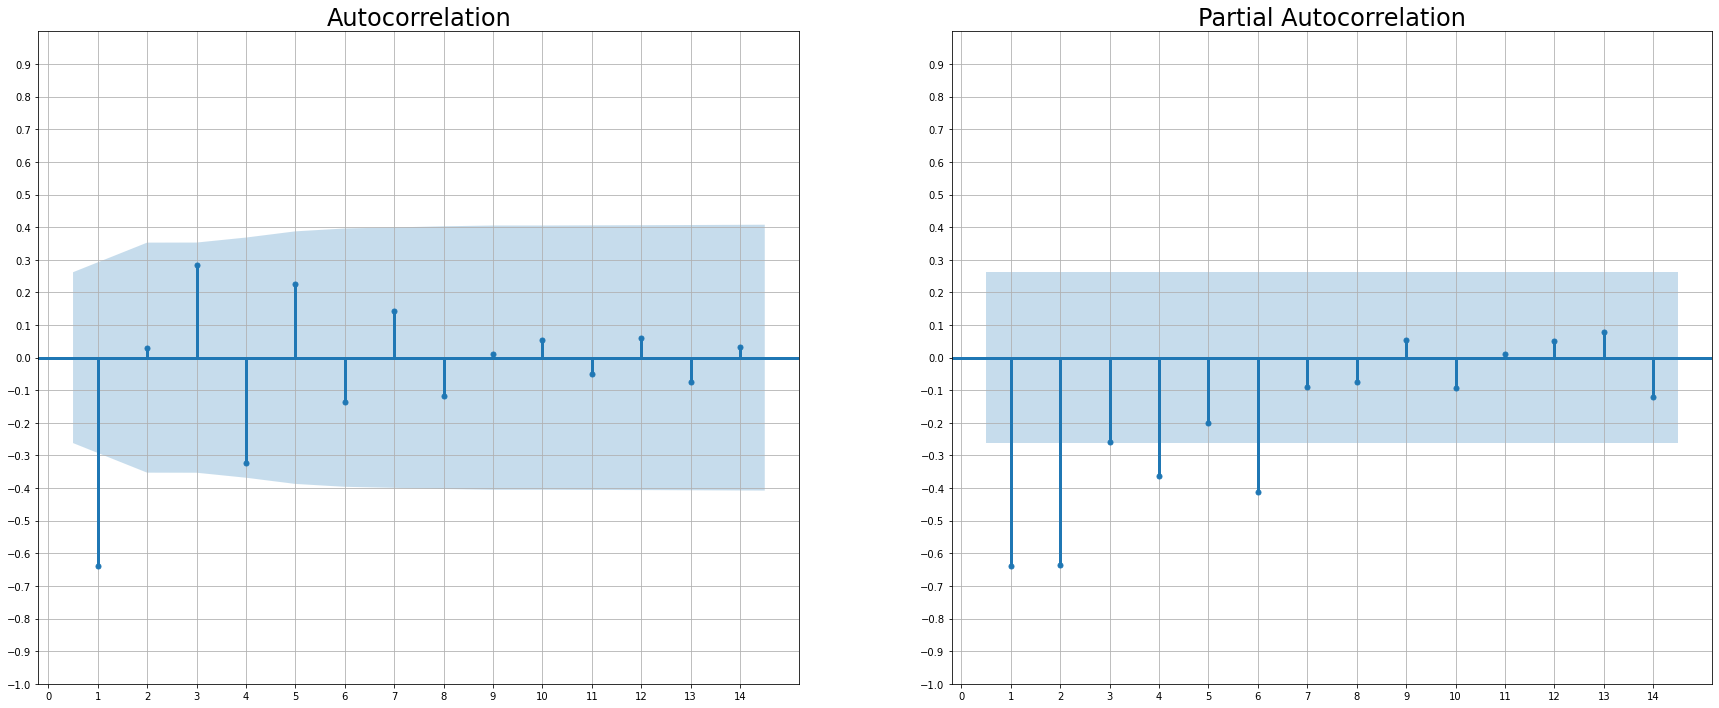

In [22]:
fig, ax = plt.subplots(1, 2)
plot_correlogram(diff_n(df_train["GDP (current US$)"], 3), plot_acf, ax[0])
plot_correlogram(diff_n(df_train["GDP (current US$)"], 3), plot_pacf, ax[1])
plt.show()

На графике автокорреляции последний лаг, отличный от нуля – лаг № 1. Соответственно, порядок модели MA будет 1.
На графике частичной автокорреляции последний лаг, отличный от нуля – лаг № 2. Соответственно, порядок модели AR будет 2.

In [23]:
p = 2
q = 1

Постройте модель с наилучшими параметрами и выполните предсказание на три года.

In [24]:
arima_model = ARIMA(df_train["GDP (current US$)"], order=(p, d, q))

In [25]:
arima_model_fit = arima_model.fit()

In [26]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 21 Feb 2023   AIC                           2659.231
Time:                        17:15:59   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

In [27]:
df_pred = pd.concat(
    [
        df["GDP (current US$)"],
        arima_model_fit.predict(start=df.index[0], end=df.index[-1]),
        arima_model_fit.get_forecast(
            len(df_test["GDP (current US$)"])
        ).conf_int(alpha=0.05),
    ],
    axis=1,
)

Отобразите результат графически.

In [29]:
def plot_forecast(df: pd.DataFrame, full: bool = True) -> None:
    """
    Строит график прогноза модели для временного ряда.

    Args:
        df: датафрейм с предсказаниями
        full: если False, то график строится только для тестовой выборки
    """
    if full:
        plt.plot(df.loc[df_train.index].iloc[:, 0], color="blue")
        plt.plot(
            df.loc[df_train.index].iloc[:, 1],
            color="orange",
            label="Predictions (train)",
        )

    plt.plot(df.loc[df_test.index].iloc[:, 0], color="blue", label="Actuals")

    plt.plot(
        df.loc[df_test.index].iloc[:, 1],
        color="red",
        label="Predictions (test)",
    )

    if df.shape[1] == 4:
        plt.plot(
            df.loc[df_test.index].iloc[:, 2].dropna(),
            color="green",
            linestyle="--",
            label="Confidence Intervals (95%)",
        )
        plt.plot(
            df.loc[df_test.index].iloc[:, 3].dropna(),
            color="green",
            linestyle="--",
        )

    plt.legend()

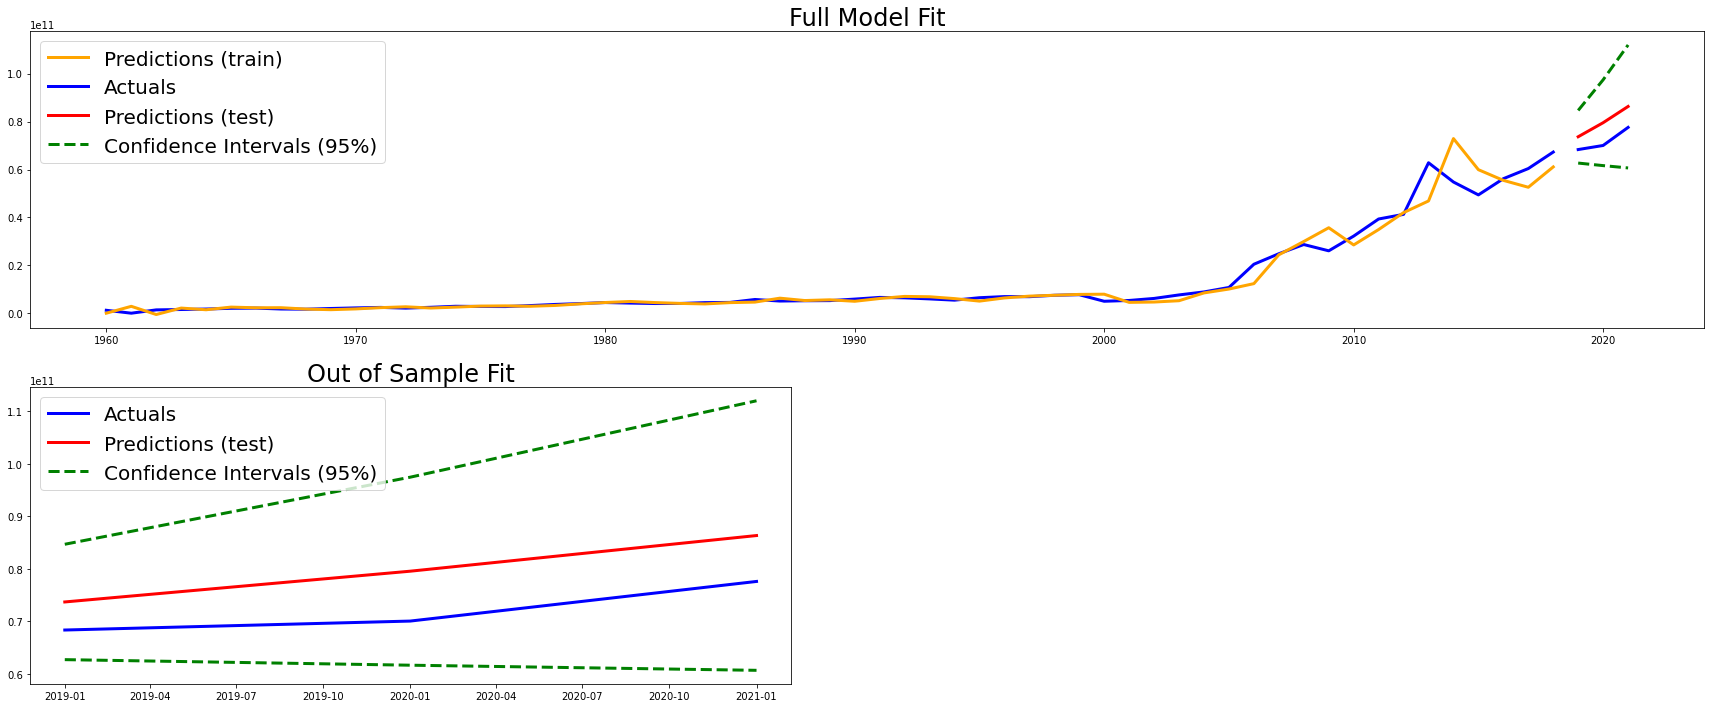

In [30]:
plt.subplot(2, 1, 1)
plot_forecast(df_pred)
plt.title("Full Model Fit")

plt.subplot(2, 2, 3)
plot_forecast(df_pred, full=False)
plt.title("Out of Sample Fit")

plt.show()

Как мы видим, модель даёт корректные предсказания.
То же самое, но с использованием pmdarima.

In [31]:
smodel = auto_arima(
    df_train["GDP (current US$)"],
    start_p=1,
    start_q=1,
    d=3,
    max_p=6,
    max_q=6,
    seasonal=False,
    test="adf",
    n_jobs=-1,
    error_action="ignore",
    trace=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.08 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.03 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.04 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.07 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.10 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.09 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.13 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.04 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.09 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.722 seconds


In [31]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Wed, 01 Feb 2023   AIC                           2659.231
Time:                        23:12:07   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

Параметры, подобранные pmdarima, совпадают с нашими – значит, мы сделали всё правильно!

# Интерполяция и сэмплирование
## Задание 1
Проверьте данные на наличие пропущенных дат.

In [35]:
df.asfreq("AS")

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


## Задание 2
Проверьте данные на наличие пропущенных значений.

In [36]:
df.isnull().sum()

GDP (current US$)    0
dtype: int64

## Задание 3
Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN.

In [37]:
df["GDP (current US$)"] = df["GDP (current US$)"].apply(
    lambda x: np.nan if x == 0 else x
)

## Задание 4
Для заполнения пропусков выполните интерполяцию с использованием метода `interpolate`.

In [38]:
df = df.interpolate(method="linear")

In [39]:
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [42]:
print(f"{df.shape=:}")

df.shape=(62, 1)


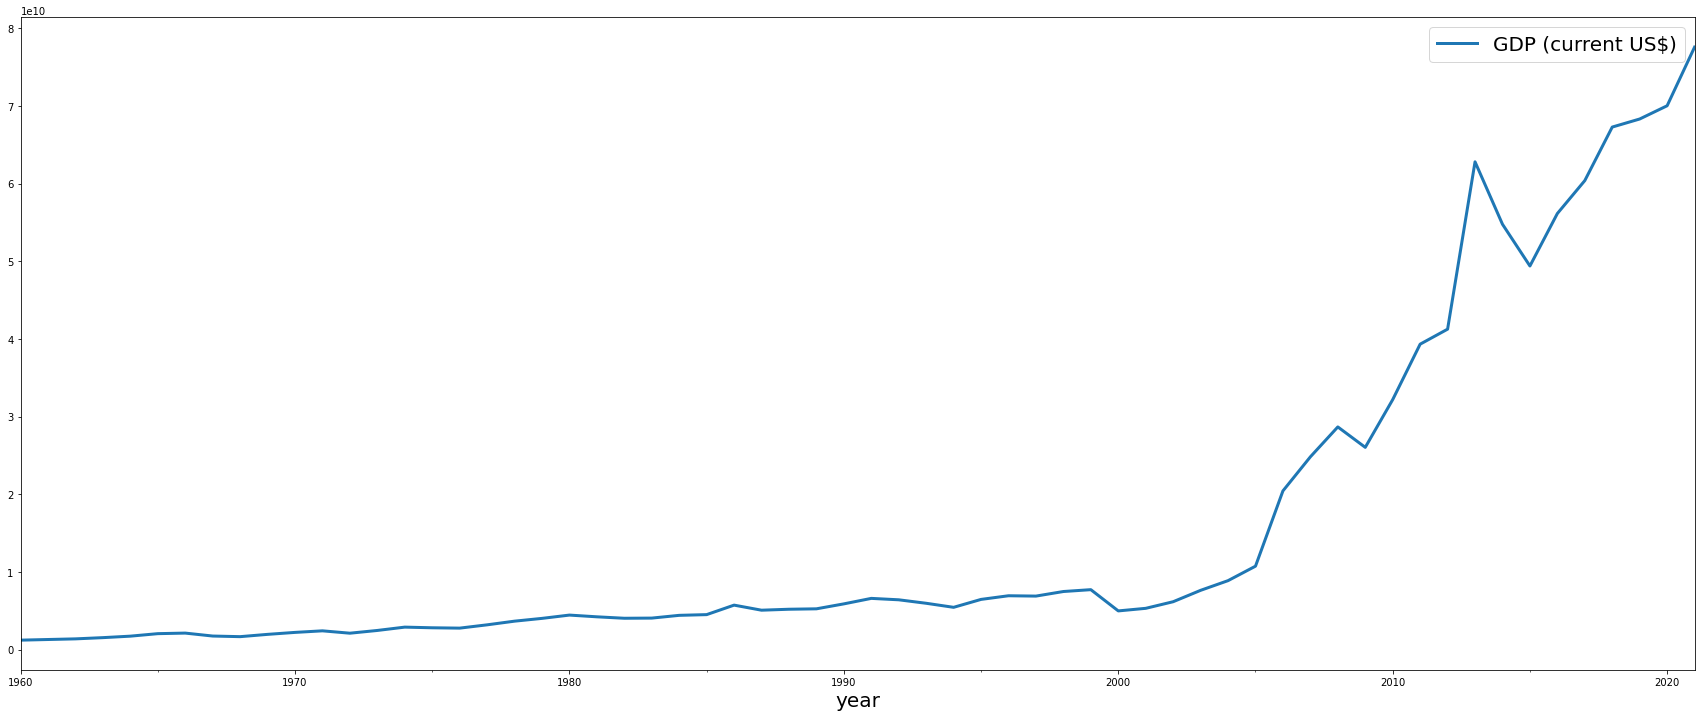

In [43]:
df.plot()
plt.show()

In [44]:
df_train = df.iloc[:-3]
df_test = df.iloc[-3:]

## Задание 6
Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

In [32]:
is_stationary(df_train["GDP (current US$)"])

adf:  0.6529066974885412
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


False

Ряд нестационарный, поэтому нам нужна модель ARIMA.

In [33]:
is_stationary(diff_n(df_train["GDP (current US$)"], 1))

adf:  -1.67024830383208
p-value:  0.446502932971388
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}


False

In [34]:
is_stationary(diff_n(df_train["GDP (current US$)"], 2))

adf:  -2.6408690561284893
p-value:  0.08484116917837681
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}


False

In [35]:
is_stationary(diff_n(df_train["GDP (current US$)"], 3))

adf:  -4.779623784828548
p-value:  5.948327640224507e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


True

Ряд является интегрированным рядом третьего порядка.

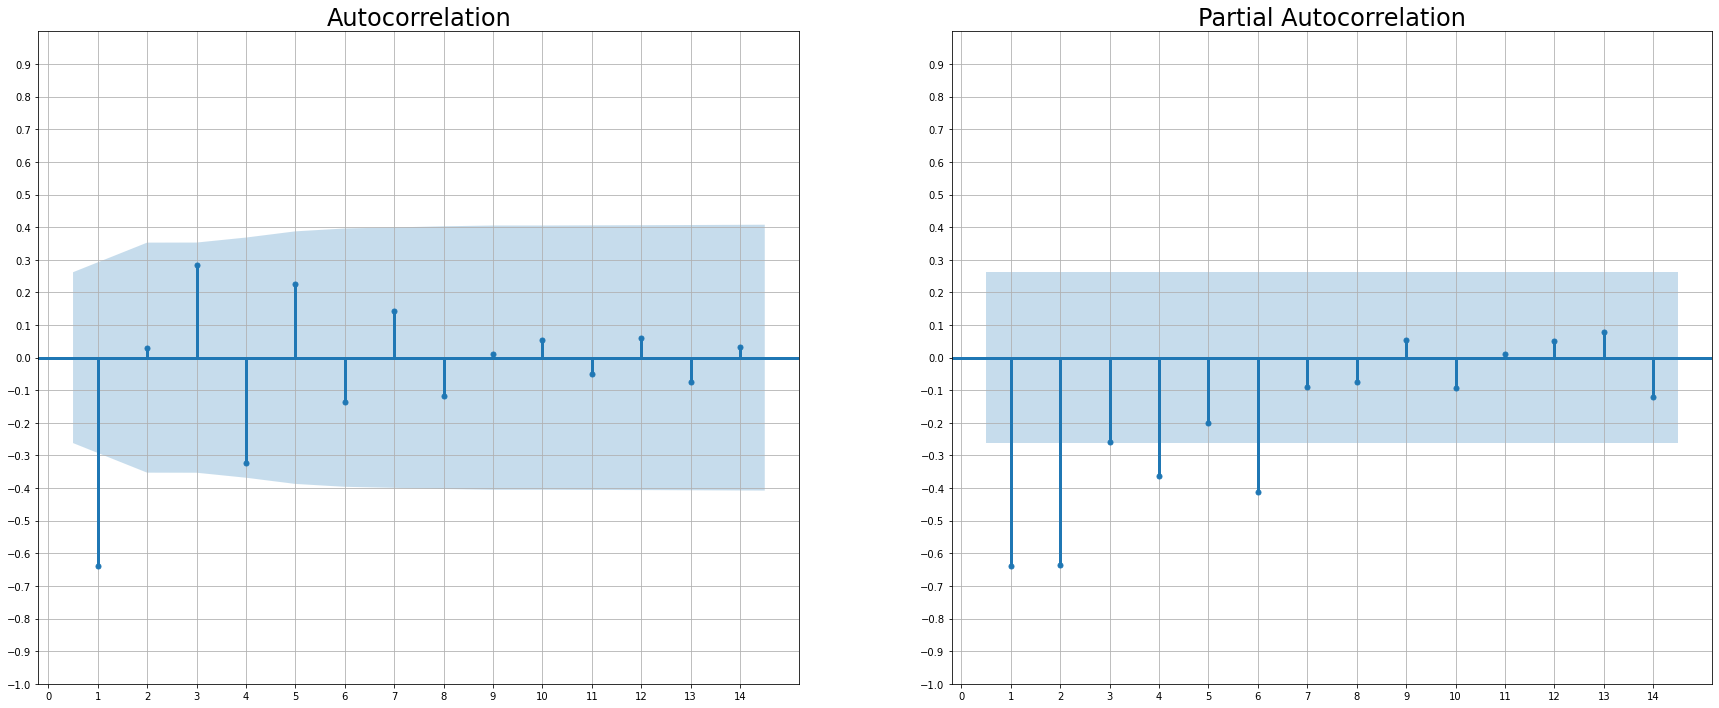

In [36]:
fig, ax = plt.subplots(1, 2)
plot_correlogram(diff_n(df_train["GDP (current US$)"], 3), plot_acf, ax[0])
plot_correlogram(diff_n(df_train["GDP (current US$)"], 3), plot_pacf, ax[1])
plt.show()

Графики корреляции не изменились, что ожидаемо.

In [37]:
arima_model = ARIMA(df_train["GDP (current US$)"], order=(p, d, q))

In [38]:
arima_model_fit = arima_model.fit()

# Задание 5
Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

In [39]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Tue, 21 Feb 2023   AIC                           2659.231
Time:                        17:19:51   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

AIC критерий незначительно упал (с 2659.231 до 2659.226). Такой небольшой прирост в качестве объясняется тем, что у нас было всего одно пропущенное значение.

In [40]:
df_pred = pd.concat(
    [
        df["GDP (current US$)"],
        arima_model_fit.predict(start=df.index[0], end=df.index[-1]),
        arima_model_fit.get_forecast(
            len(df_test["GDP (current US$)"])
        ).conf_int(alpha=0.05),
    ],
    axis=1,
)

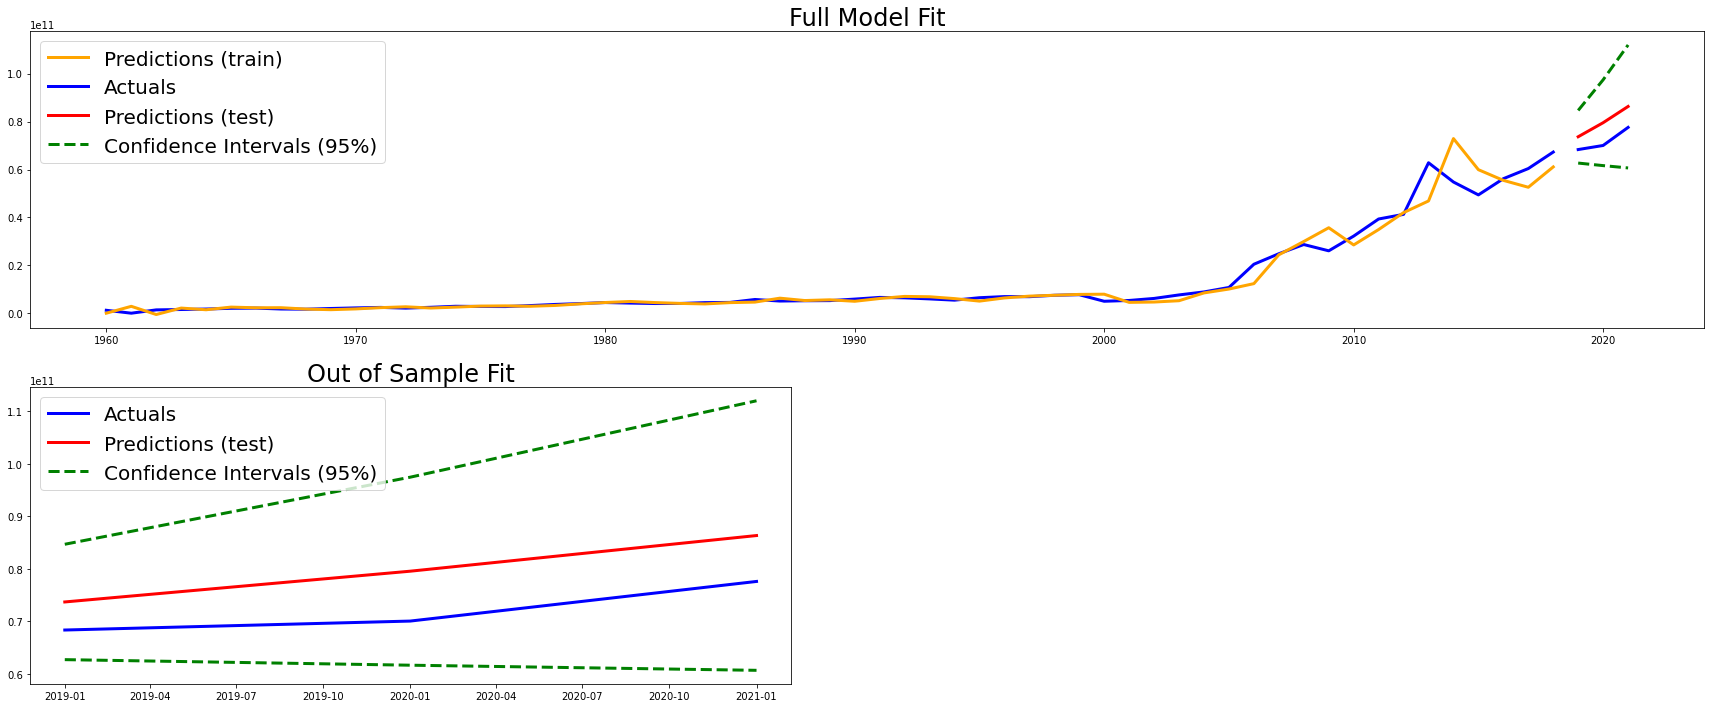

In [41]:
plt.subplot(2, 1, 1)
plot_forecast(df_pred)
plt.title("Full Model Fit")

plt.subplot(2, 2, 3)
plot_forecast(df_pred, full=False)
plt.title("Out of Sample Fit")

plt.show()

# Модели прогнозирования гетероскедастичности. Валидация временных рядов.
## Задание 1
Посчитайте волатильность для вашего временного ряда.

In [61]:
df["volatility"] = df["GDP (current US$)"].pct_change().abs()

In [62]:
df["volatility"].head()

year
1960-01-01         NaN
1961-01-01    0.067894
1962-01-01    0.063578
1963-01-01    0.114488
1964-01-01    0.123636
Name: volatility, dtype: float64

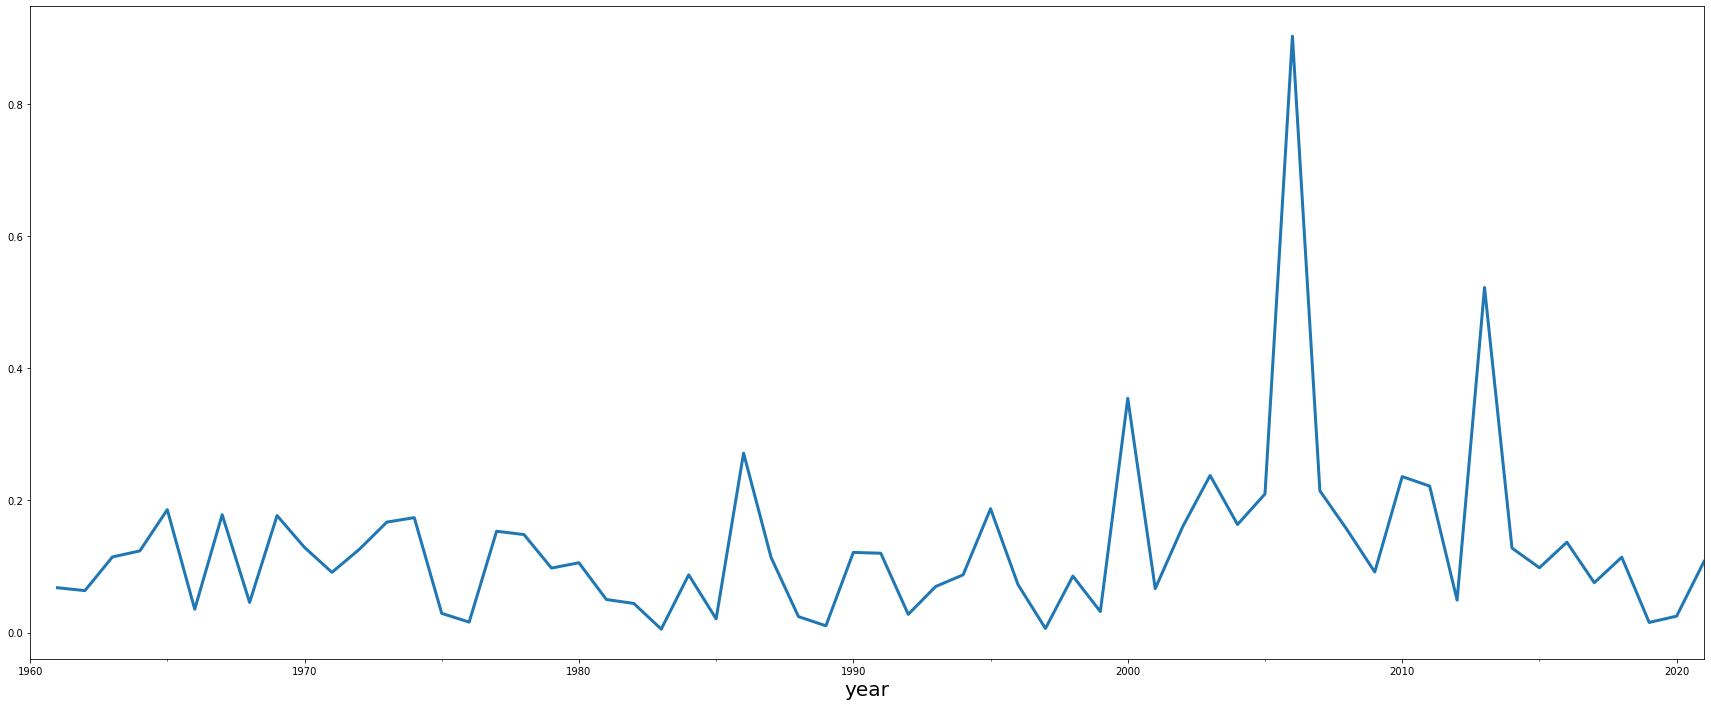

In [63]:
df["volatility"].plot()
plt.show()

По графику волатильности видим, что есть явные всплески дисперсии. Попробуем провести предсказание этой дисперсии.

In [64]:
df = df.drop(columns="GDP (current US$)")

In [65]:
df_train = df.iloc[:-3]
df_test = df.iloc[-3:]

In [66]:
is_stationary(df_train["volatility"][1:])

adf:  -6.725311059553776
p-value:  3.4014596148856737e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}


True

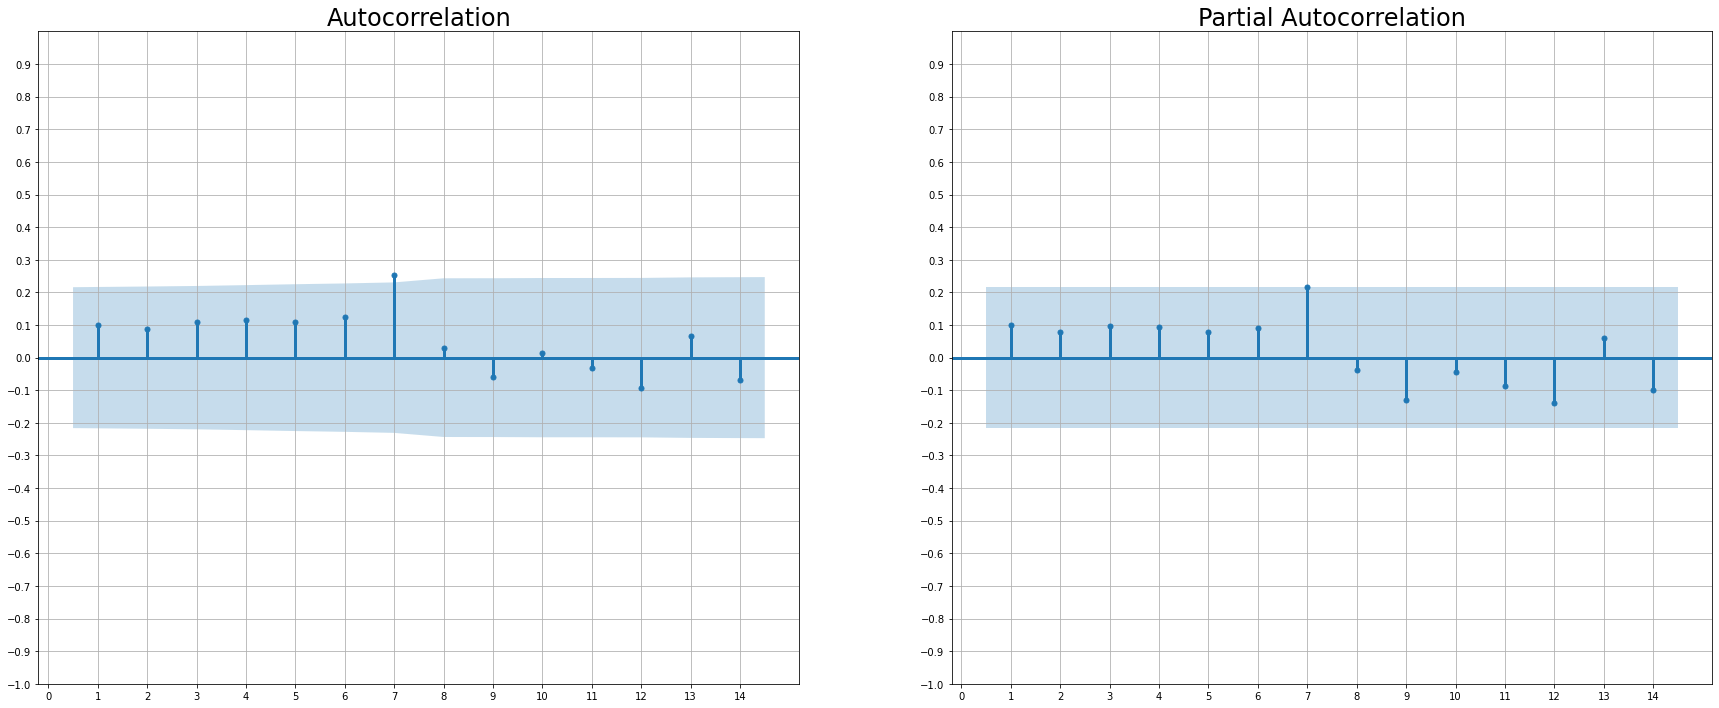

In [67]:
fig, ax = plt.subplots(1, 2)
plot_correlogram(df_train["volatility"][1:], plot_acf, ax[0], alpha=0.1)
plot_correlogram(df_train["volatility"][1:], plot_pacf, ax[1], alpha=0.1)
plt.show()

На графиках автокорреляции и частичной автокорреляции последний лаг, отличный от нуля – лаг № 7. Соответственно, берём параметры модели p=7, q=7.

In [95]:
p = 7
q = 7

## Задание 2
Используйте GARCH-модель для предсказания волатильности.

In [96]:
model = arch_model(df["volatility"].dropna(), p=p, q=q, vol="GARCH")

In [97]:
model_results = model.fit(last_obs=df_test.index[0], update_freq=5)

Iteration:      5,   Func. Count:     98,   Neg. LLF: -10.222715395298785
Iteration:     10,   Func. Count:    190,   Neg. LLF: -52.61750111441449
Iteration:     15,   Func. Count:    275,   Neg. LLF: -53.03500402817808
Iteration:     20,   Func. Count:    360,   Neg. LLF: -53.09232284873572
Optimization terminated successfully    (Exit mode 0)
            Current function value: -53.092377676492255
            Iterations: 22
            Function evaluations: 393
            Gradient evaluations: 22


In [98]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                53.0924
Distribution:                  Normal   AIC:                          -74.1848
Method:            Maximum Likelihood   BIC:                          -41.2177
                                        No. Observations:                   58
Date:                Wed, Feb 01 2023   Df Residuals:                       57
Time:                        20:47:35   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1186  1.559e-02      7.607  2.799e-14 [8.803e-02,  0.149]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.4232e-03  4.165e-03      1.062      0.288 [-3.740e-03,1.259e-02]
alpha[1]       0.0000  7.583e-02      0.000      1.000      [ -0.149,  0.149]
alpha[2]       0.0000  2.283e-02      0.000      1.000 [-4.475e-02,4.475e-02]
alpha[3]       0.0000  6.755e-02      0.000      1.000      [ -0.132,  0.132]
alpha[4]   3.5931e-03  1.462e-02      0.246      0.806 [-2.507e-02,3.226e-02]
alpha[5]       0.0000  1.261e-02      0.000      1.000 [-2.471e-02,2.471e-02]
alpha[6]       0.7331      0.905      0.810      0.418      [ -1.040,  2.506]
alpha[7]       0.1023      0.630      0.162      0.871      [ -1.132,  1.336]
beta[1]        0.0000      0.491      0.000      1.000      [ -0.963,  0.963]
beta[2]        0.0000  6.039e-02      0.000      1.000      [ -0.118,  0.118]
beta[3]        0.0000  2.829e-02      0.000      1.000 [-5.544e-02,5.544e-02]
beta[4]        0.0000  8.960e-02      0.000      1.000      [ -0.176,  0.176]
beta[5]        0.0000  5.223e-02      0.000      1.000      [ -0.102,  0.102]
beta[6]        0.0000  2.985e-02      0.000      1.000 [-5.851e-02,5.851e-02]
beta[7]        0.0000      1.130      0.000      1.000      [ -2.215,  2.215]
=============================================================================

Covariance estimator: robust
"""

In [99]:
df_test["prediction"] = model_results.forecast(
    reindex=True
).residual_variance.loc[df_test.index]

In [100]:
mse = round(mean_squared_error(df_test.iloc[:, 0], df_test.iloc[:, 1]), 3)

mse=0.004


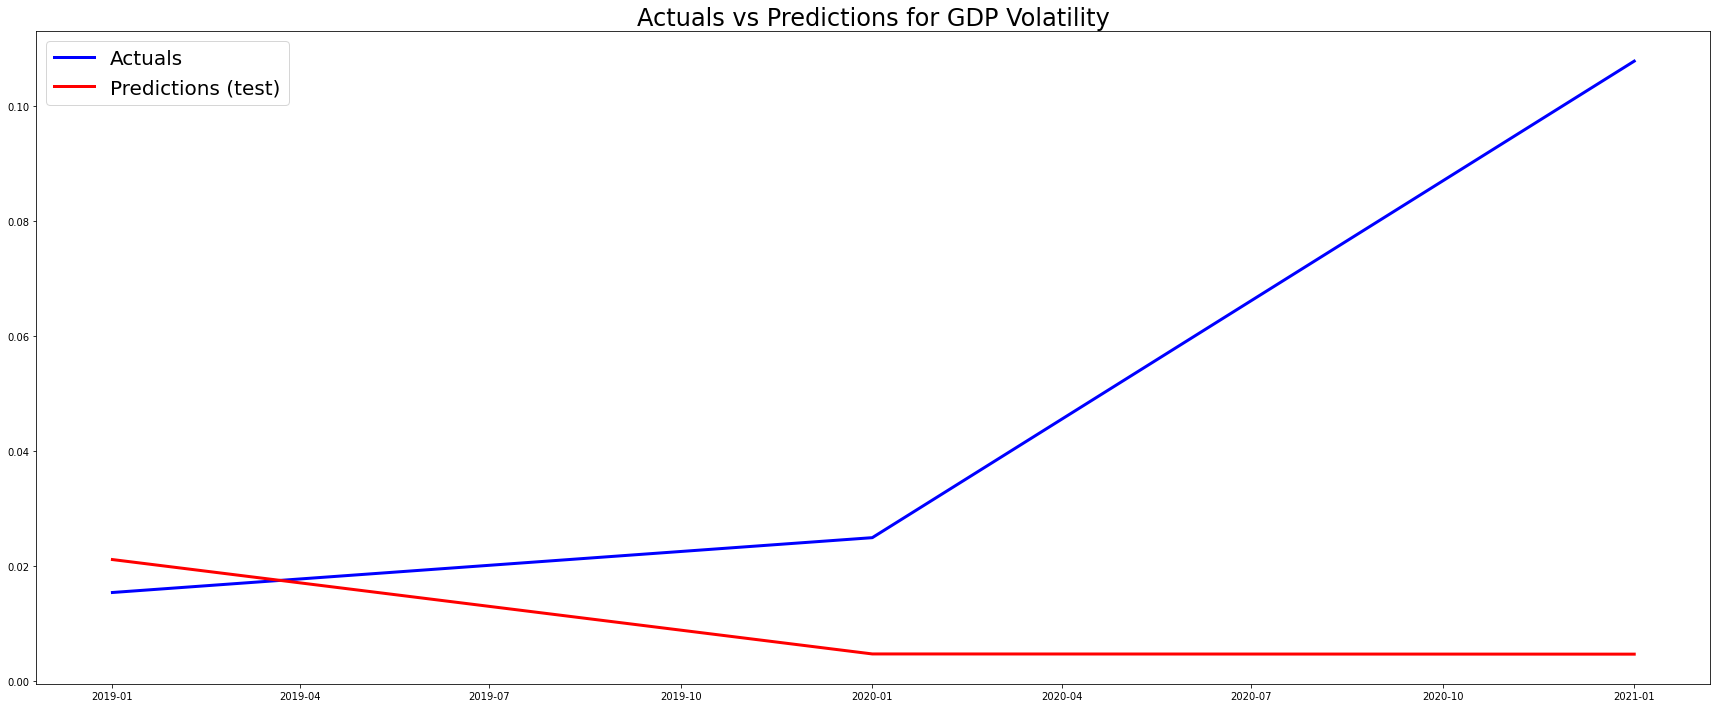

In [101]:
print(f"{mse=:.3f}")
plot_forecast(df_test, full=False)
plt.title("Actuals vs Predictions for GDP Volatility")
plt.show()

Модель GARCH даёт хорошую MSE. Также она уловила изгиб в тестовых данных.

## Задание 3
Используйте линейную регрессию для получения прогноза.

In [102]:
X_train = pd.DataFrame(range(len(df_train)))
X_test = pd.DataFrame(range(len(df)))[-len(df_test) :]
y_train = df_train["volatility"].fillna(0)
y_test = df_test["volatility"]

In [103]:
regr = LinearRegression()

In [104]:
regr.fit(X_train, y_train)

LinearRegression()

In [105]:
df_test["prediction"] = regr.predict(X_test)

## Задание 4
Визуализируйте полученное предсказание вместе с фактическим значением.

In [106]:
mse = round(mean_squared_error(df_test.iloc[:, 0], df_test.iloc[:, 1]), 3)

mse=0.025


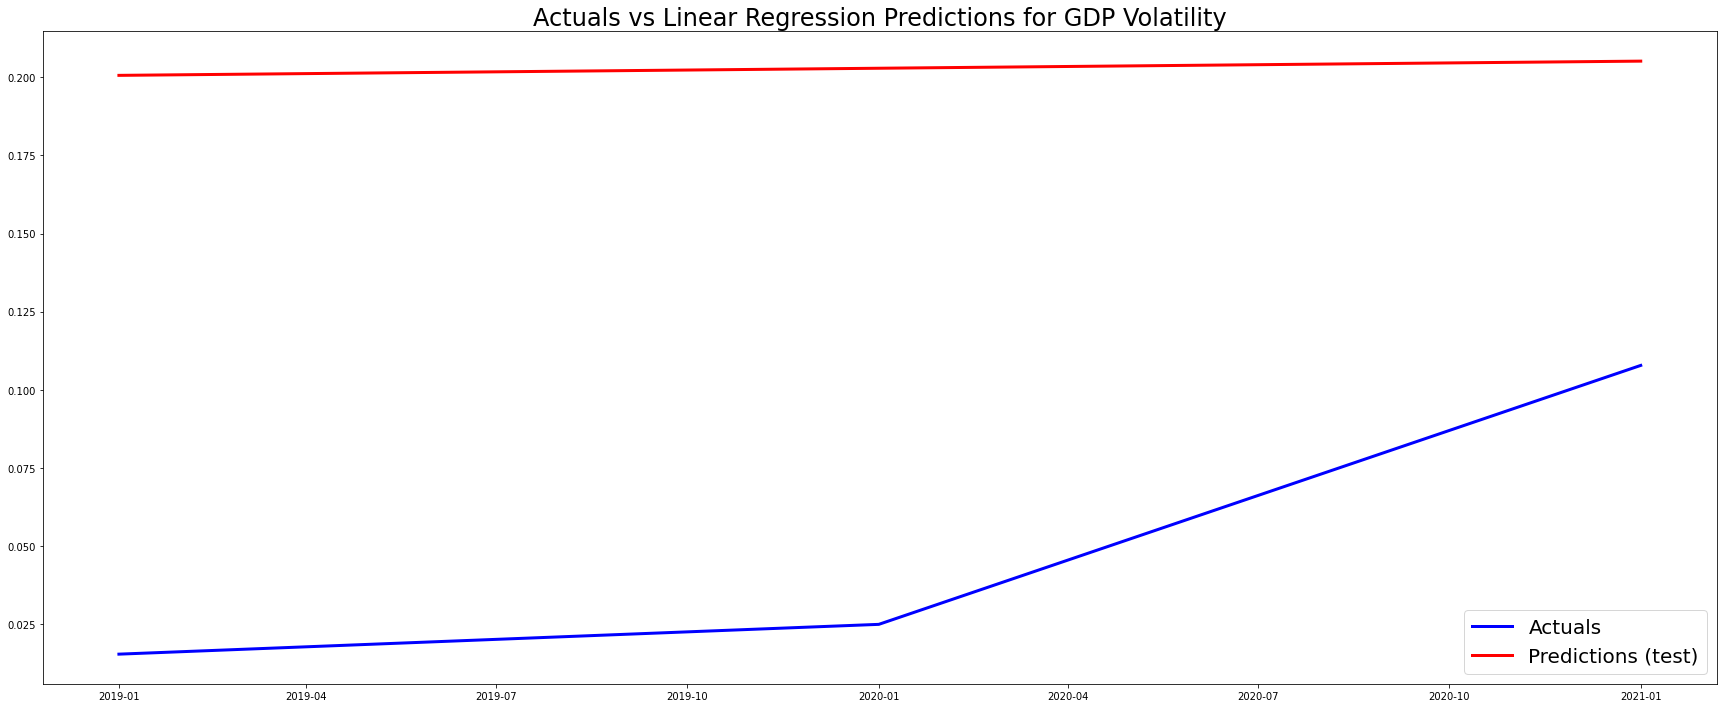

In [107]:
print(f"{mse=:.3f}")
plot_forecast(df_test, full=False)
plt.title("Actuals vs Linear Regression Predictions for GDP Volatility")
plt.show()

MSE линейной регрессии в 6.25 раз больше, чем у модели GARCH. Также линейная регрессия не уловила "изгиб" в тестовых данных (график предсказаний имеет вид прямой линии).

Модель GARCH с правильно подобранными параметрами, ожидаемо, работает немного лучше линейной регрессии.

Попробуем модель Prophet.

In [108]:
df = df.reset_index()

In [109]:
df.columns = ["ds", "y"]

In [110]:
df.head()

,ds,y
0,1960-01-01,NaN
1,1961-01-01,0.067894
2,1962-01-01,0.063578
3,1963-01-01,0.114488
4,1964-01-01,0.123636


In [111]:
df_train = df.iloc[:-3]
df_test = df.iloc[-3:]

In [112]:
model = Prophet()

In [113]:
model.fit(df_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/td/2zhlxcg531n6ttp901cv66lc0000gp/T/tmpnez71e1h/_7_zqxpu.json
DEBUG:cmdstanpy:input tempfile: /var/folders/td/2zhlxcg531n6ttp901cv66lc0000gp/T/tmpnez71e1h/z5jr1t43.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11579', 'data', 'file=/var/folders/td/2zhlxcg531n6ttp901cv66lc0000gp/T/tmpnez71e1h/_7_zqxpu.json', 'init=/var/folders/td/2zhlxcg531n6ttp901cv66lc0000gp/T/tmpnez71e1h/z5jr1t43.json', 'output', 'file=/var/folders/td/2zhlxcg531n6ttp901cv66lc0000gp/T/tmpnez71e1h/prophet_modeleu94xnv9/prophet_model-20230201205107.csv', 'method=optimize', 'algorith

In [114]:
df_pred = model.predict(df[["ds"]])[["ds", "yhat", "yhat_lower", "yhat_upper"]]

In [115]:
df_pred.tail()

,ds,yhat,yhat_lower,yhat_upper
57,2017-01-01,0.207121,0.035255,0.374624
58,2018-01-01,0.205285,0.038092,0.366227
59,2019-01-01,0.196055,0.041364,0.370772
60,2020-01-01,0.179445,0.014539,0.352520
61,2021-01-01,0.215780,0.042877,0.377134


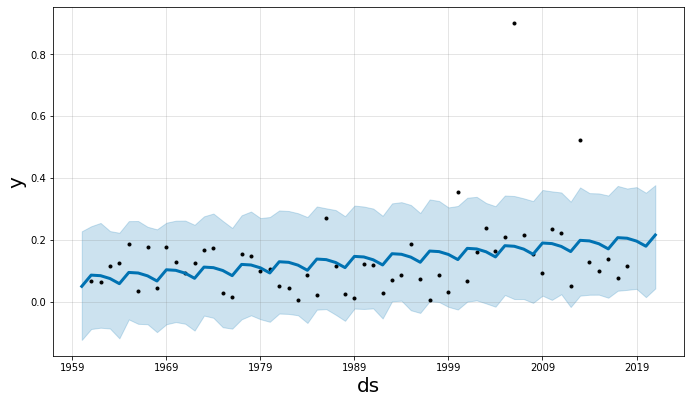

In [116]:
# вся модель выглядет так
fig = model.plot(df_pred)

In [117]:
df = df.set_index("ds")
df_train = df_train.set_index("ds")
df_test = df_test.set_index("ds")
df_pred = df_pred.set_index("ds")

df_pred.insert(0, "y_true", df["y"])

In [118]:
mse = round(mean_squared_error(df_test["y"], df_pred.iloc[-3:]["yhat"]), 3)

mse=0.023


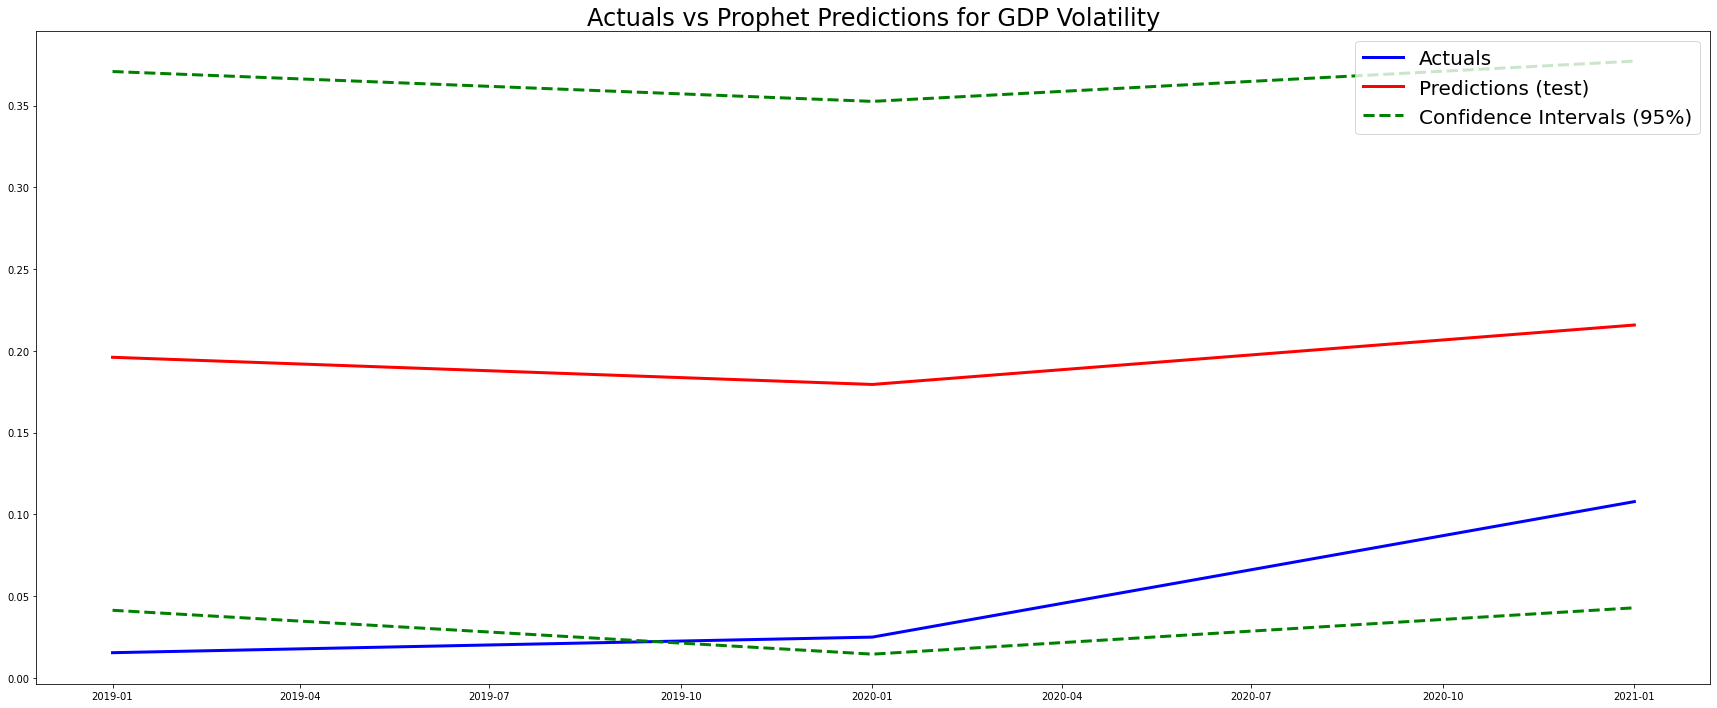

In [119]:
print(f"{mse=:.3f}")
plot_forecast(df_pred, full=False)
plt.title("Actuals vs Prophet Predictions for GDP Volatility")
plt.show()

Модель Prophet уловила перегиб в средней точке тестовых данных, но тоже даёт высокое (по сравнению с моделью GARCH) значение ошибки.